# Practical work 7: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+NomImageBase[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(NomImageBase[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [2]:
def quantize(I, k):
    """ float -> int 
    """
    if I == 1: return k-1
    intervalles = np.linspace(0,1,num=k+1)
    #print(intervalles)
    for x in range(k):
        if I>=intervalles[x] and I < intervalles [x+1]:
            return x
    
    

# You can test your function with the following lines:
# print(quantize(1,8))
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1

assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantificationImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [3]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    Iq = I.copy()
    hist = np.zeros((nH,nS,nV))
    for x in range(len(I)):
        for y in range(len(I[x])):
            h,s,v = I[x][y]
            h,s,v = quantize(h,nH), quantize(s,nS), quantize(v,nV)
            hist[h][s][v] += 1
            Iq[x][y] = np.array([h,s,v])
    return Iq,hist


3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [4]:
def normalize(H):
    """ Array -> Array"""
    norm  = np.linalg.norm(H,2)
    return H/norm

5) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


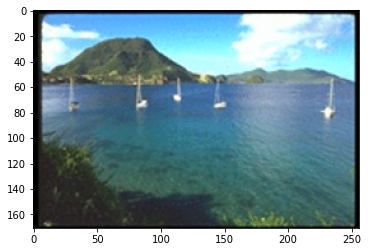

239.0625


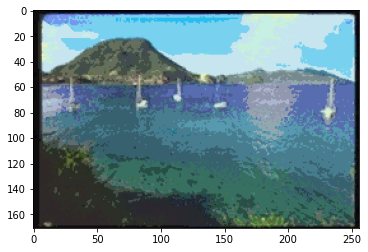

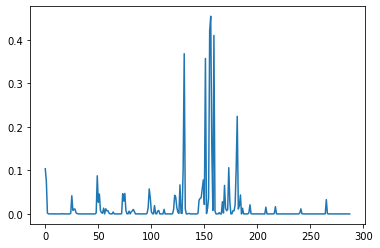

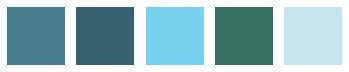

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [5]:

PathImage = './Base/'
nom = 'Paysages67.png'  # to be completed

# quantization parameters
nH = 12 # to be completed
nS = 3 # to be completed
nV = 8 # to be completed


filename= nom;
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# conversion RGB->HSV
J = rgb2hsv(I)

# color palette computation
palette, palette2 = setColors( nH, nS , nV );

# Image quantization (your function)
Iq, histo = quantizeImage(J, nH, nS, nV)

# Visualisation of quantized image
viewQuantizedImage(Iq , palette2)

# print(histo)
# flat a 3D histogram to 1D
histo = histo.flat
# print(np.array(histo))
# Histogram normalization (your function)
histo = normalize(histo)
# print(histo)
plt.figure()
plt.plot(histo)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

display5mainColors(histo, palette)

print(hsv_most_prevalent)

6) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

In [6]:
def content_search(nom,nH,nS,nV):
    
    PathImage = './Base/'
    filename= nom;
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]
    plt.figure();
    plt.imshow(I);
    plt.show()

    # conversion RGB->HSV
    J = rgb2hsv(I)

    # color palette computation
    palette, palette2 = setColors( nH, nS , nV );

    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)

    # Visualisation of quantized image
    viewQuantizedImage(Iq , palette2)

    # print(histo)
    # flat a 3D histogram to 1D
    histo = histo.flat
    # print(np.array(histo))
    # Histogram normalization (your function)
    histo = normalize(histo)
    # print(histo)
    plt.figure()
    plt.plot(histo)
    plt.show()

    ## Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

    display5mainColors(histo, palette)

    print(hsv_most_prevalent)

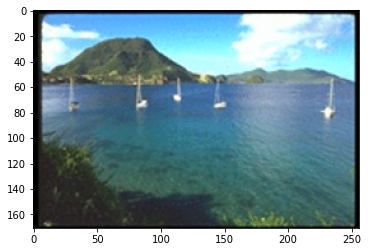

242.25000000000003


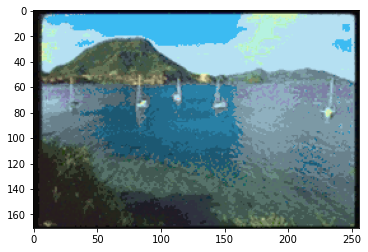

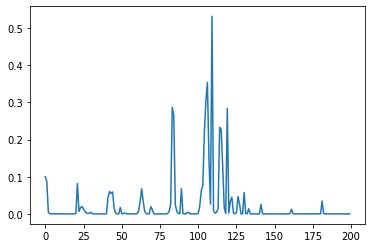

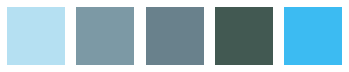

[(5, 0, 9), (5, 0, 6), (5, 0, 5), (4, 0, 3), (5, 1, 9)]


In [8]:
content_search('Paysages67.png',10,2,10) # peu de valeurs claires

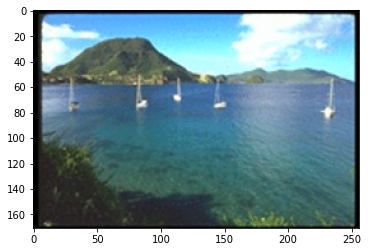

242.25000000000003


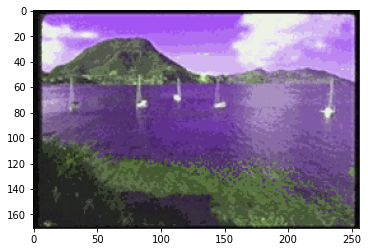

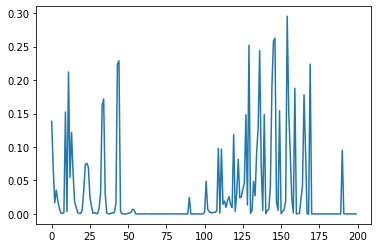

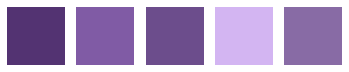

[(1, 5, 4), (1, 4, 6), (1, 4, 5), (1, 2, 9), (1, 3, 6)]


In [9]:
content_search('Paysages67.png',2,10,10) #peu de couleurs

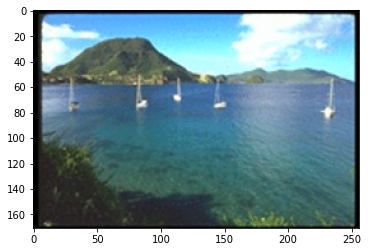

191.25


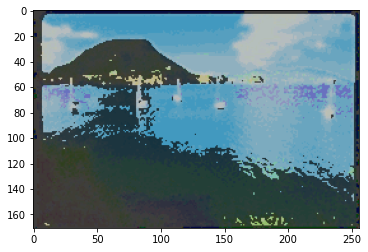

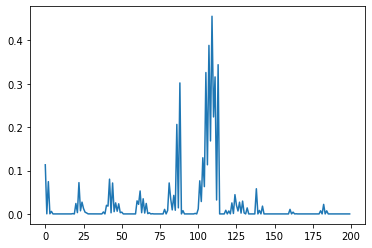

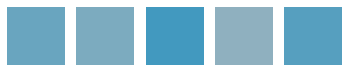

[(5, 4, 1), (5, 3, 1), (5, 6, 1), (5, 2, 1), (5, 5, 1)]


In [10]:
content_search('Paysages67.png',10,10,2) # peu de valeurs sombres

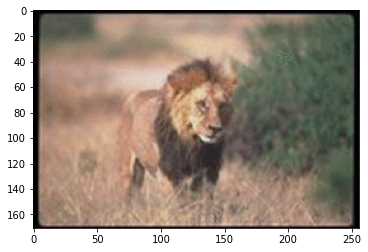

242.25000000000003


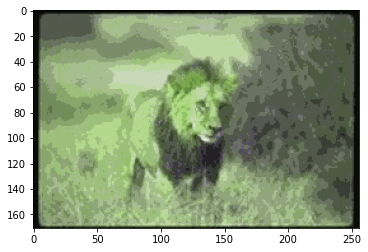

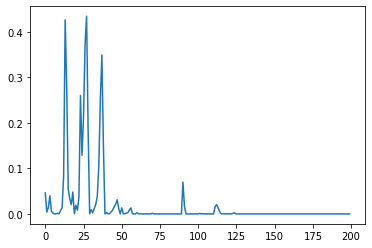

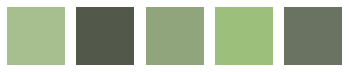

[(0, 2, 7), (0, 1, 3), (0, 2, 6), (0, 3, 7), (0, 1, 4)]


In [11]:
content_search('Liontigre99.png',2,10,10)

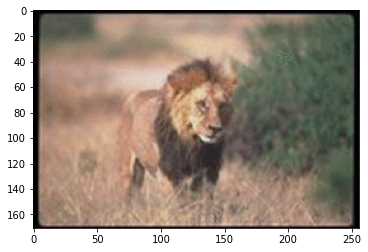

242.25000000000003


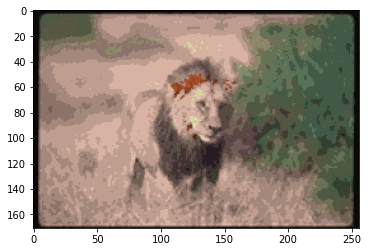

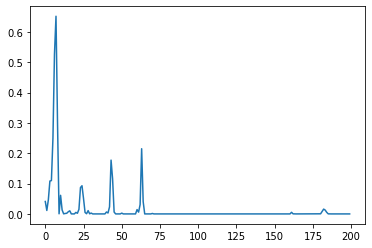

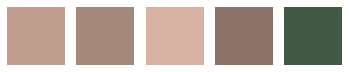

[(0, 0, 7), (0, 0, 6), (0, 0, 8), (0, 0, 5), (3, 0, 3)]


In [12]:
content_search('Liontigre99.png',10,2,10)

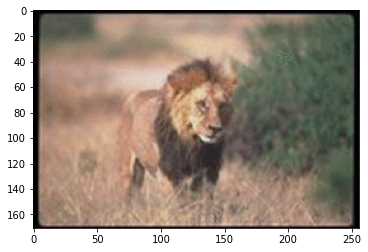

191.25


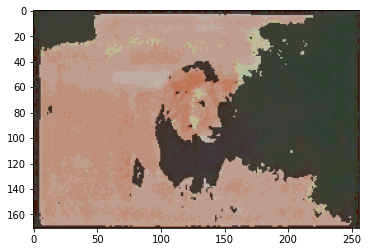

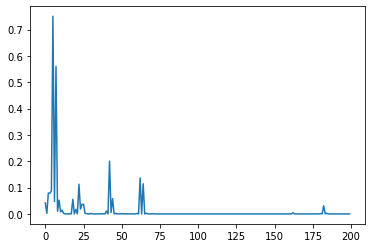

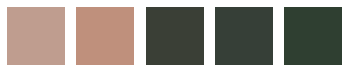

[(0, 2, 1), (0, 3, 1), (2, 1, 0), (3, 1, 0), (3, 2, 0)]


In [13]:
content_search('Liontigre99.png',10,10,2)

7) What can you say about the results?

nH change le nombre de teintes de couleurs, ainsi si celui-ci est faible  on aura peu de couleurs dans l'histogramme.  
nS change le nombre de teintes de clair, ainsi si celui-ci est faible, on aura peut de teintes claires pour une même couleur dans l'histogramme.  
nV change le nombre de teintes de sombre, ainsi si celui-ci est faible, on aura peut de teintes sombres pour une même couleur dans l'histogramme.  
Pour différencer des images très colorer il est donc plus simple d'avoir un nH fort.  
Si on a des images semblables avec des changements de luminosités que l'on veut regrouper, un nV et nS faible est une bonne idée.  

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [15]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
listImage = os.listdir(pathImage)
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = False # Set to False to compute the histogramm database

if not bcomputed:
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation ... it may take a while ...
Sunsets95.png
Liontigre96.png
Paysages6.png
Textures71.png
Elephant16.png
Sunsets21.png
Portraits15.png
Paysages18.png
Sunsets94.png
Voitures32.png
Textures130.png
Paysages96.png
Liontigre37.png
Voitures44.png
Sunsets84.png
Elephant87.png
Sunsets36.png
Voitures96.png
Aeriennes21.png
Paysages20.png
Fleche34.png
Avions16.png
Textures39.png
Ours__10.png
Avions86.png
Liontigre15.png
Textures46.png
Paysages21.png
Paysages42.png
Voitures12.png
Avions10.png
Voitures51.png
Voitures70.png
Bestioles6.png
Bestioles74.png
Avions5.png
Portraits65.png
Avions80.png
Paysages8.png
Voitures38.png
Elephant67.png
Fleche11.png
Textures5.png
Bestioles80.png
Liontigre68.png
Elephant11.png
Sunsets22.png
Paysages44.png
Voitures93.png
Sunsets24.png
Bestioles37.png
Elephant21.png
Paysages65.png
Sunsets43.png
Liontigre82.png
Fleche5.png
Liontigre84.png
Textures55.png
Textures152.png
Textures101.png
Paysages50.png
Elephant85.png
Textures8.png
Avions26.png


Paysages29.png
Elephant17.png
Elephant83.png
Liontigre92.png
Voitures67.png
Liontigre69.png
Fleche42.png
Avions65.png
Bestioles27.png
Textures165.png
Paysages92.png
Bestioles36.png
Sunsets50.png
Avions60.png
Bestioles34.png
Bestioles56.png
Elephant1.png
Portraits18.png
Sunsets38.png
Elephant15.png
Elephant13.png
Paysages80.png
Bestioles2.png
Elephant44.png
Textures167.png
Voitures99.png
Avions22.png
Ours__34.png
Bestioles60.png
Voitures39.png
Elephant90.png
Textures132.png
Avions97.png
Textures9.png
Avions41.png
Portraits29.png
Liontigre65.png
Bestioles33.png
Sunsets70.png
Elephant79.png
Liontigre44.png
Bestioles38.png
Sunsets5.png
Paysages56.png
Liontigre24.png
Voitures5.png
Sunsets56.png
Bestioles1.png
Liontigre35.png
Paysages63.png
Ours__28.png
Sunsets35.png
Textures105.png
Sunsets91.png
Portraits20.png
Avions57.png
Liontigre97.png
Sunsets73.png
Ours__12.png
Voitures37.png
Bestioles30.png
Portraits16.png
Sunsets28.png
Sunsets31.png
Avions1.png
Textures24.png
Avions56.png
Liontigre95

### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [16]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

def similarityMatrix(listHisto):
    return np.matmul(listHisto,listHisto.T)

2. Display the matrix `S`  as an image. What can we say about this it ?

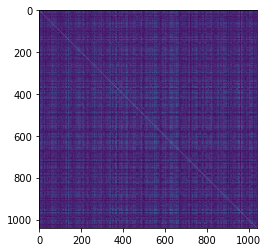

In [17]:
S = similarityMatrix(listHisto)
plt.imshow(S)

On observe des valeurs fortes sur la diagonale, en effet celle-ci correspond à l'image elle-même donc on a une forte similarité. Pour le reste les valeurs sont beaucoup plus faibles.

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

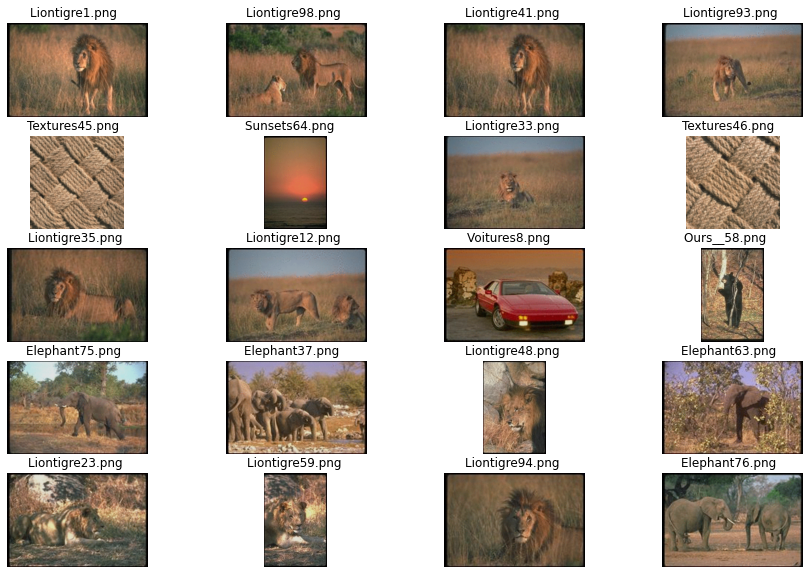

In [18]:
NomImageBase = listImage
indexQuery = 658
#print(NomImageBase[658])
#for i,x in enumerate(NomImageBase):
#    if np.char.equal(x,np.str('Liontigre1.png')):
#        print(i)
display20bestMatches(S, indexQuery)
imageName = (pathImage+NomImageBase[indexQuery]).strip()


4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


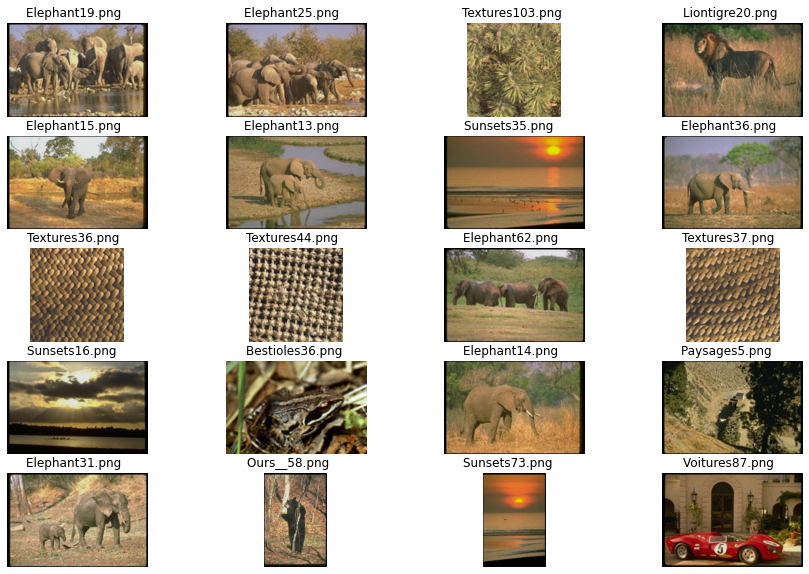

In [165]:
import random
r = random.randrange(1031)
display20bestMatches(S, r)
imageName = (pathImage+NomImageBase[r]).strip()


5. What can you say about the results ? What are the limitations and the advantages of this method ?

On observe beaucoup d'erreurs sur des images de même couleur mais avec des objets différents.  
Une limite de cette methode est que cela dépend des couleurs de l'image mais pas des formes, ainsi savoir qu'un ours blanc et la même chose qu'un ours noir est tres difficile avec cette méthode.  
On ne fait pas la différence non plus entre le fond et l'objet que l'on cherche.  
Cette méthode à l'air plutot efficace pour distinguer les paysages, on le voit notamment dans la question 3 où toutes les images sont dans la savane.